In [1]:
# Import packages
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings('ignore')

In [7]:
import os
import numpy as np
import matplotlib.pyplot as plt
import scarlet

import kuaizi as kz
from kuaizi.display import display_single, display_rgb, SEG_CMAP
from kuaizi.detection import Data
from kuaizi.utils import padding_PSF

import unagi

import astropy.units as u
from astropy import wcs
from astropy.io import fits
from astropy.table import Table, Column, vstack
from astropy.coordinates import SkyCoord, match_coordinates_sky
from astropy.convolution import convolve, Gaussian2DKernel

In [8]:
from kuaizi.fit import ScarletFitter, fitting_obs_tigress

In [9]:
env_dict = {'project': 'HSC', 'name': 'LSBG', 'data_dir': '/scratch/gpfs/jiaxuanl/Data'}
kz.utils.set_env(**env_dict)
kz.utils.set_matplotlib(style='default', usetex=False)

In [10]:
lsbg_cat = Table.read('./Catalog/mock_sample/mock_obj_cat_0_1000.fits')
# lsbg_cat['image_flag'] = np.ones(len(lsbg_cat), dtype=bool)
# lsbg_cat['psf_flag'] = np.ones(len(lsbg_cat), dtype=bool)
print('# of LSBGs:', len(lsbg_cat))
channels = 'griz'

# of LSBGs: 1000


In [11]:
lsbg = lsbg_cat[911]

In [12]:
lsbg

<Row index=911>
viz-id         ra                 dec             mag_auto_i         sersic_n          sersic_ell         sersic_PA      sersic_rhalf_circ               sersic_sed [4]                              mags [4]                            prefix            image_flag [4] psf_flag [4]
int64       float64             float64            float64           float64            float64            float64            float64                       float64                                  float64                            bytes65                 bool          bool    
------ ------------------ ------------------- ----------------- ------------------ ------------------ ------------------ ------------------ ---------------------------------------- --------------------------------------- ----------------------------- -------------- ------------
   911 130.29424132660634 -1.2853043954519225 18.59318387977945 0.9628080695496515 0.4741485207906875 -85.39359079915971 12.341631926323371 0.5503702843709162 .. 1.1474881963932673 19.24154643626988 .. 18.443813312595278 ./Cutout/mock_sample/mock_911   True .. True True .. True

### Running scarlet wavelet modeling for `./Cutout/mock_sample/mock_911`
    Working directory: /scratch/gpfs/jiaxuanl/Data/HSC/LSBG
  - Detect sources and make mask
    Query GAIA stars...
    Taking Gaia catalogs stored in `Tigress`
    7 stars from Gaia are masked!
    Detected 114 objects
    7 stars from Gaia are masked!
    Detected 87 objects
    Detected 48 objects
  - Wavelet modeling with the following hyperparameters:
    min_grad = -0.10, starlet_thresh = 1.00 (contam_ratio = 0.12).
    Total number of sources: 19
    Optimizaiton: Succeed for e_rel = 0.0001 with 68 iterations! Try higher accuracy!
    Optimizaiton: Succeed for e_rel = 0.0005 with 108 iterations! Try higher accuracy!
  - After 108 iterations, logL = 1127233.21
    Elapsed time for fitting: 68.67 s
  - Components [0] are considered as the target galaxy.
  - Masking stars and other sources that are modeled, to deal with leaky flux issue.
  - Saving the results as /scratch/gpfs/jiaxuanl/Data/HSC/LSBG/Model/moc

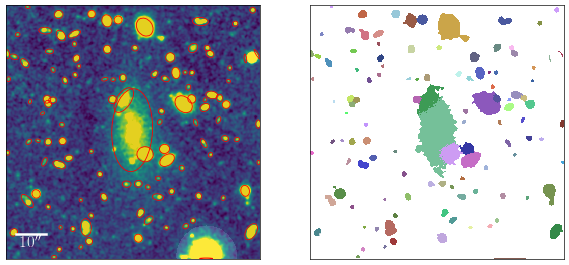

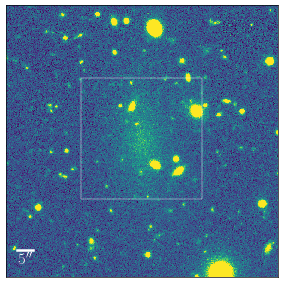

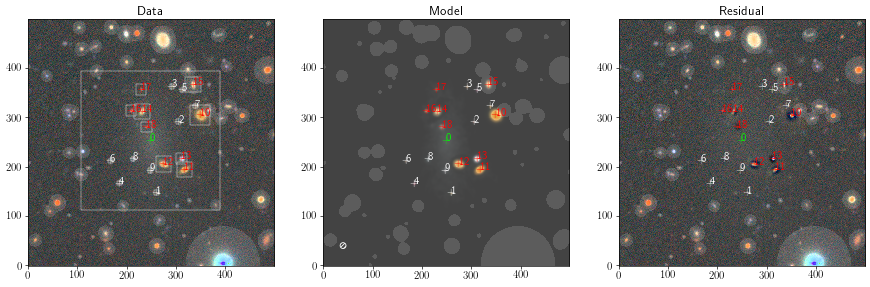

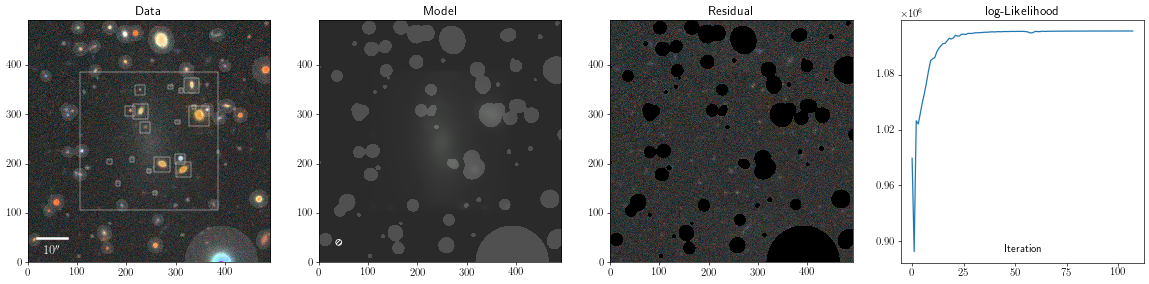

In [419]:
fitting_obs_tigress(env_dict, 
                    lsbg, 
                    name='viz-id',
                    method='wavelet', 
                    starlet_thresh=1,
                    prefix='mock', 
                    model_dir='./Model/mock_sample/',
                    figure_dir='./Figure/mock_sample',
                    log_dir='./log/mock_sample',
                    show_figure=True)

In [13]:
prefix = 'LSBG'
channels = 'griz'
index = lsbg['viz-id']

bright = (lsbg['mag_auto_i'] < 17)
print('Bright =', bright)

lsbg_coord = SkyCoord(ra=lsbg['ra'], dec=lsbg['dec'], unit='deg')
cutout = [fits.open(f"{lsbg['prefix']}_{band}.fits") for band in channels]
psf_list = [fits.open(f"{lsbg['prefix']}_{band}_psf.fits") for band in channels]

images = np.array([hdu[1].data for hdu in cutout])
# note: all bands share the same WCS here, but not necessarily true.
w = wcs.WCS(cutout[0][1].header)
weights = 1.0 / np.array([hdu[3].data for hdu in cutout])
weights[np.isinf(weights)] = 0.0
psf_pad = padding_PSF(psf_list)  # Padding PSF cutouts from HSC
psfs = scarlet.ImagePSF(np.array(psf_pad))
# saturation mask and interpolation mask from HSC S18A
sat_mask = np.array([sum(unagi.mask.Mask(
    hdu[2].data, data_release='s18a').extract(['INTRP', 'SAT'])) for hdu in cutout])
data = Data(images=images, weights=weights, masks=sat_mask,
            wcs=w, psfs=psfs, channels=channels)

Bright = False


In [14]:
fitter = ScarletFitter(method='wavelet', tigress=True, starlet_thresh=1,
                       model_dir='./Model/mock_sample/',
                        figure_dir='./Figure/mock_sample',
                        log_dir='./log/mock_sample',
                       prefix='mock', 
                       index=lsbg['viz-id'], 
                       show_figure=True)
fitter.load_data(data, lsbg_coord)

  - Detect sources and make mask
    Query GAIA stars...
    Taking Gaia catalogs stored in `Tigress`
    4 stars from Gaia are masked!
    Detected 92 objects
    4 stars from Gaia are masked!
    Detected 81 objects
    Detected 37 objects
  - Wavelet modeling with the following hyperparameters:
    min_grad = -0.10, starlet_thresh = 1.00 (contam_ratio = 0.06).
    Total number of sources: 36
    Optimizaiton: Succeed for e_rel = 0.0001 with 101 iterations! Try higher accuracy!
    Optimizaiton: Succeed for e_rel = 0.0005 with 141 iterations! Try higher accuracy!
  - After 141 iterations, logL = 1233663.16
    Elapsed time for fitting: 99.05 s
  - Components [0] are considered as the target galaxy.
  - Masking stars and other sources that are modeled, to deal with leaky flux issue.
  - Saving the results as /scratch/gpfs/jiaxuanl/Data/HSC/LSBG/Model/mock_sample/mock-216-trained-model-wavelet.df


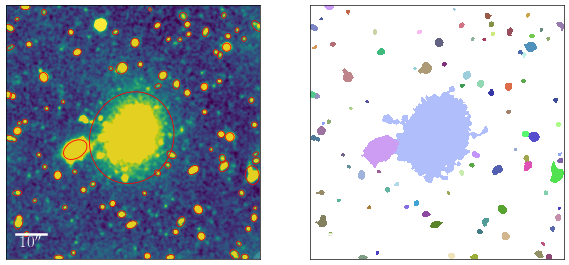

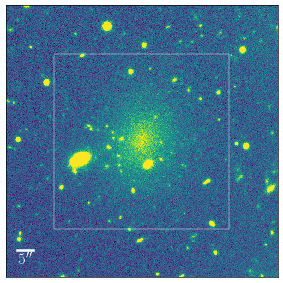

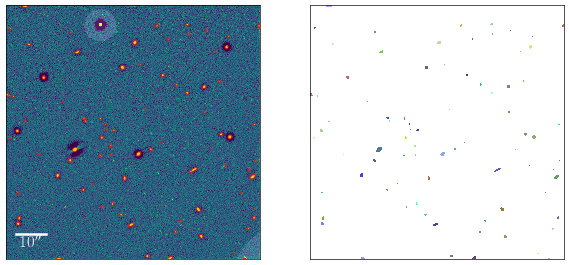

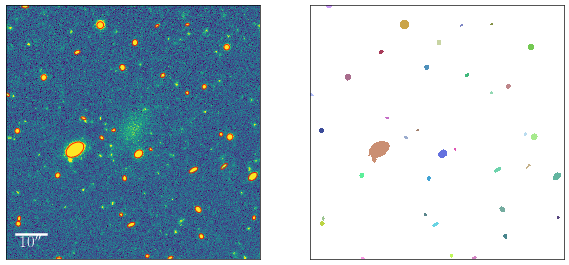

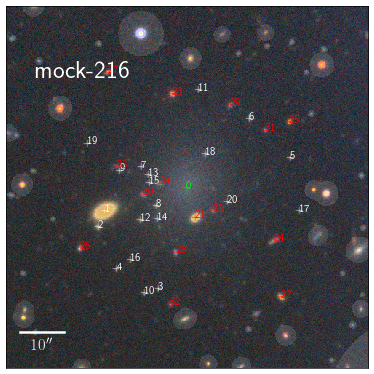

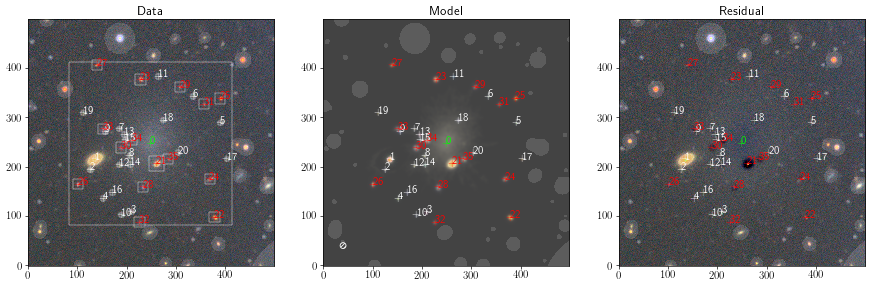

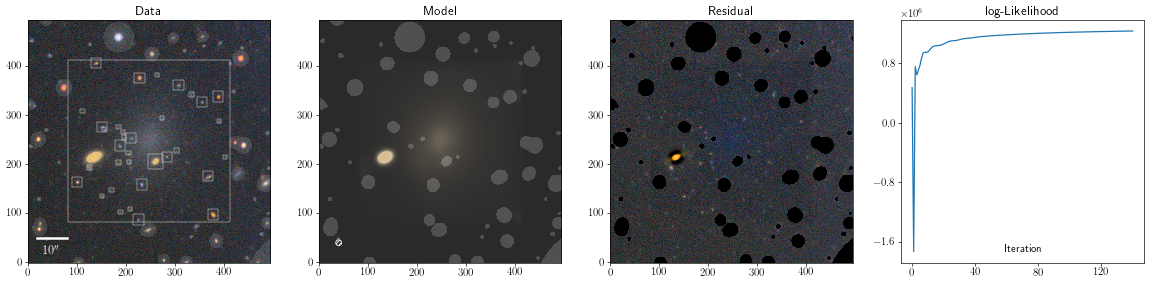

In [253]:
fitter.fit()

#### Step-by-step

In [16]:
fitter._first_gaia_search()

    Query GAIA stars...
    Taking Gaia catalogs stored in `Tigress`
    7 stars from Gaia are masked!


In [52]:
# Set the weights of saturated star centers to zero
# In order to make the box size estimation more accurate.
temp = np.copy(fitter.data.masks)
for i in range(len(fitter.data.channels)):
    temp[i][~fitter.msk_star_ori.astype(bool)] = 0
    fitter.data.weights[i][temp[i].astype(bool)] = 0.0

[autoreload of scarlet.interpolation failed: Traceback (most recent call last):
  File "/projects/HSC/LSST/stack_20200903/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/projects/HSC/LSST/stack_20200903/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 394, in superreload
    module = reload(module)
  File "/projects/HSC/LSST/stack_20200903/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/imp.py", line 314, in reload
    return importlib.reload(module)
  File "/projects/HSC/LSST/stack_20200903/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 630, in _exec
  File "<frozen importlib._bootstrap_external>", line 728, in 

    Detected 114 objects


TypeError: __init__() got an unexpected keyword argument 'lvl'

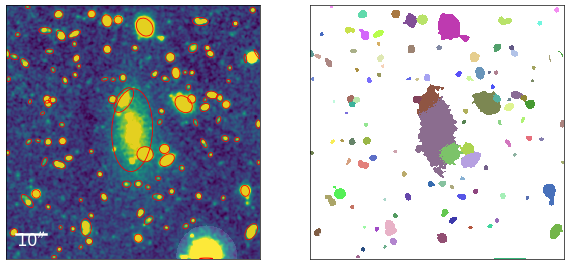

In [53]:
# Replace the vanilla detection with a convolved vanilla detection
first_dblend_cont = 0.07 if max(
    fitter.data.images.shape) * fitter.pixel_scale > 200 else 0.006

if fitter.method == 'wavelet':
    first_dblend_cont = 0.07 if max(
    fitter.data.images.shape) * fitter.pixel_scale > 200 else 0.006
        
fitter._first_detection(first_dblend_cont)

In [40]:
from scarlet import Starlet

In [ ]:
fitter.data.images[0]

In [22]:
wvlt = Starlet.from_image(fitter.data.images[0])

In [23]:
wvlt.scales

7

In [28]:
from scipy.stats import median_absolute_deviation as mad

In [38]:
from scarlet.wavelet import mad_wavelet

In [47]:
wvlt = Starlet(fitter.data.images[0], lvl=7)

In [48]:
wvlt.coefficients.shape

(1, 7, 499, 499)

In [43]:
mad(wvlt.coefficients[:, 0, ...], axis=(-2, -1))

array([0.03492241])

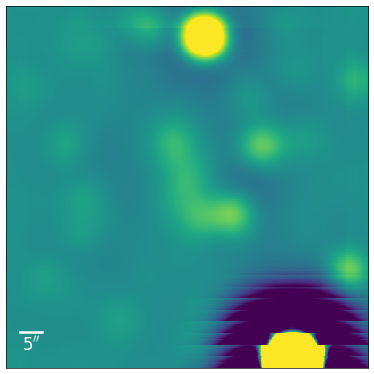

In [51]:
display_single(wvlt.coefficients[0, 5, ...]);

In [ ]:
fitter._estimate_box(fitter.cen_obj)

In [ ]:
fitter._mask_stars_outside_box()

In [ ]:
fitter._cpct_obj_detection()

In [ ]:
from kuaizi.display import draw_circles

In [ ]:
fitter._big_obj_detection()

In [ ]:
draw_circles(fitter.data.images[0], fitter.obj_cat_big)

In [ ]:
fitter._merge_catalogs()

In [ ]:
fitter._construct_obs_frames()

In [ ]:
fitter._add_sources()

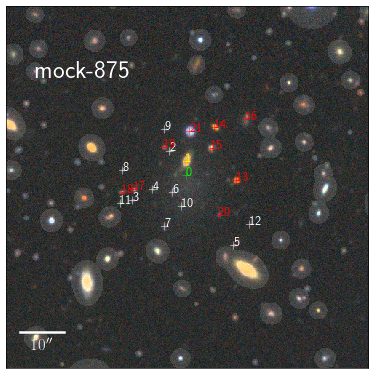

In [364]:
fig = kz.display.display_scarlet_sources(
        fitter.data,
        fitter._sources,
        show_ind=None,
        stretch=1,
        Q=1,
        minimum=-0.3,
        show_mark=True,
        scale_bar_length=10,
        add_text=f'{fitter.prefix}-{fitter.index}')

[<AxesSubplot:title={'center':'Data'}>,
 <AxesSubplot:title={'center':'Model'}>,
 <AxesSubplot:title={'center':'Residual'}>]

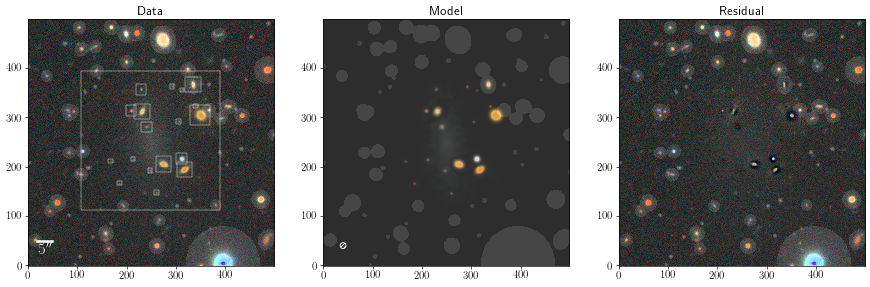

In [411]:
kz.display.display_scarlet_model(
    fitter.blend,
    #show_ind=[0],
    #zoomin_size=50,
    minimum=-0.2,
    stretch=1,
    add_boxes=True,
    channels='griz',
    show_mask=False,
    show_mark=False, 
    show_loss=False)

    Optimizaiton: Succeed for e_rel = 0.0001 with 68 iterations! Try higher accuracy!
    Optimizaiton: Succeed for e_rel = 0.0005 with 108 iterations! Try higher accuracy!
  - After 108 iterations, logL = 1127233.21
    Elapsed time for fitting: 67.68 s


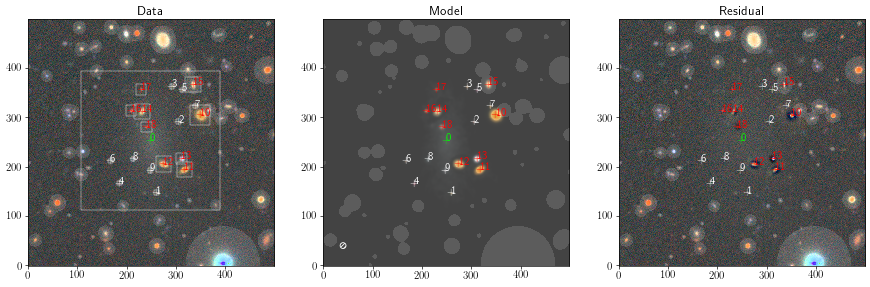

In [412]:
fitter._optimize()

In [413]:
fitter._find_sed_ind()

  - Components [0] are considered as the target galaxy.


In [414]:
fitter._gen_final_mask()

  - Masking stars and other sources that are modeled, to deal with leaky flux issue.
  - Saving the results as /scratch/gpfs/jiaxuanl/Data/HSC/LSBG/Model/mock_sample/mock-911-trained-model-wavelet.df


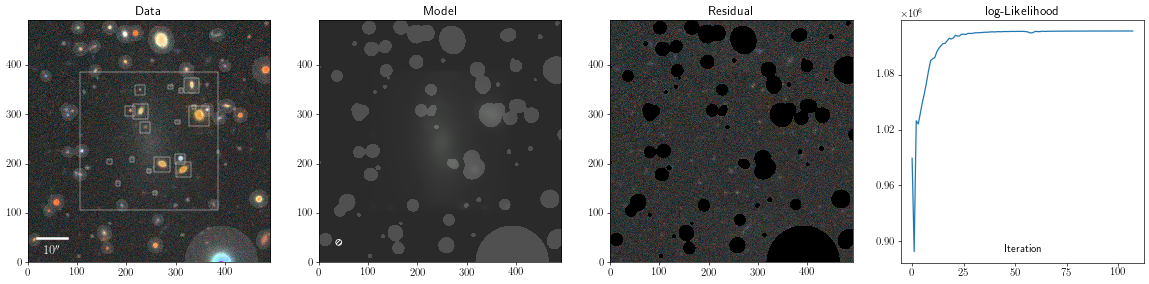

In [415]:
fitter._display_results()

In [21]:
import PIL.Image

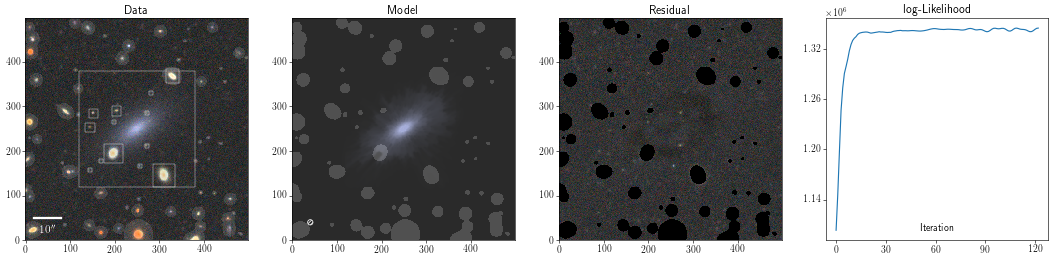

In [23]:
PIL.Image.open('./Figure/mock_sample/mock-0-zoomin-vanilla.png')